In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import string
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED = 42


**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/bb11ace54b1a465e91b8c3f46a840ce0)**

# Загрузка и чистка 

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/kaggle/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/kaggle/test.csv')
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

In [ ]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [ ]:
train_df.sentence = train_df.sentence.str.replace('[0-9:!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',repl='', regex=True)
train_df.sentence = train_df.sentence.str.replace('quot',repl='', regex=True)

train_df['len'] = train_df.sentence.str.len()
train_df = train_df.iloc[train_df.len.values > 0, :]
LE = LabelEncoder().fit(train_df.language)
y = LE.transform(train_df.language)

In [ ]:
train_df.head()

,sentence,language,len
0,Pensez à la communication le discours les ge...,fr,155
1,Můžete si ji pronajmout vzít na splátky koup...,cs,207
2,Každý starosta pochopil že když mají tyto for...,cs,76
3,Det är ytterligare bevis men ändå — Jag kriti...,sv,167
4,كان الأمر لا يصدق,ar,18


## Удаляю вбросы ))

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
spisok = []
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox').fit(train_df.len.values[y == i].reshape(-1, 1))
    train_df.iloc[y == i, 2] = PW.transform(train_df.len.values[y == i].reshape(-1, 1))
    spisok.append(PW)



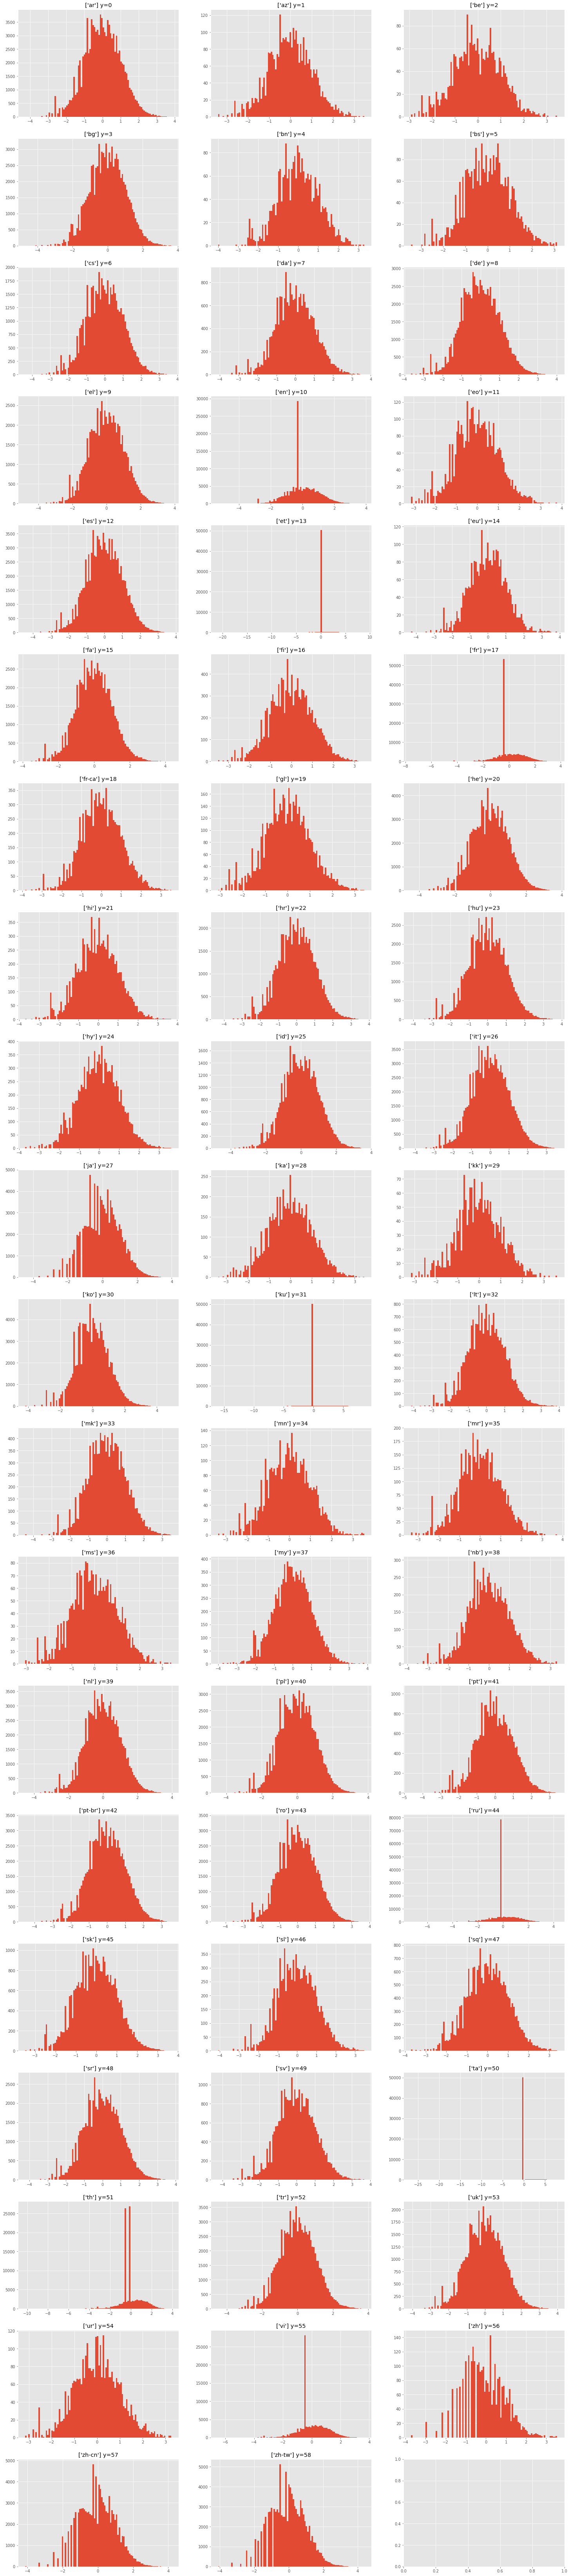

In [ ]:
fig, ax = plt.subplots(20, 3, figsize=(25,120))
n, k, i = 0, 0, 0
while i < 59:
    if n < 3:
        ax[k, n].hist(train_df.len[y == i].values, bins = 100)
        ax[k, n].set_title(str(LE.inverse_transform(np.array([i]))) + ' y='+ str(i))
        n += 1
        i += 1
    else:
        k += 1
        n = 0

In [ ]:
train_df.iloc[y == 10, :].head(30)

s10 = train_df.sentence[345]
mask10 = train_df.sentence.values != s10

s13 = train_df.sentence[51]
mask13 = train_df.sentence.values != s13

s17 = train_df.sentence[110]
mask17 = train_df.sentence.values != s17

s31 = train_df.sentence[34]
mask31 = train_df.sentence.values != s31

s44 = train_df.sentence[26]
mask44 = train_df.sentence.values != s44

s50 = train_df.sentence[164]
mask50 = train_df.sentence.values != s50

s51_1 = train_df.sentence[74]
s51_2 = train_df.sentence[243]
mask51 = (train_df.sentence.values != s51_1) * (train_df.sentence.values != s51_2)


s55 = train_df.sentence[86]
mask55 = (train_df.sentence.values != s55)


mask_all = mask10 * mask13 * mask17 * mask31 * mask44 * mask50 * mask51 * mask55

In [ ]:
train_df = train_df.iloc[mask_all, :]
y = y[mask_all]

In [ ]:
# train_df.shape

In [ ]:
# train_df.iloc[y == 13., :].head(30)

In [ ]:
# Перехожу в исходный масштаб по длине
for i, PW in enumerate (spisok):
    train_df.iloc[y == i, 2] = PW.inverse_transform(train_df.len.values[y == i].reshape(-1, 1))

## Результаты чистки

In [ ]:
spisok1 = []
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox').fit(train_df.len.values[y == i].reshape(-1, 1))
    train_df.iloc[y == i, 2] = PW.transform(train_df.len.values[y == i].reshape(-1, 1))
    spisok1.append(PW)

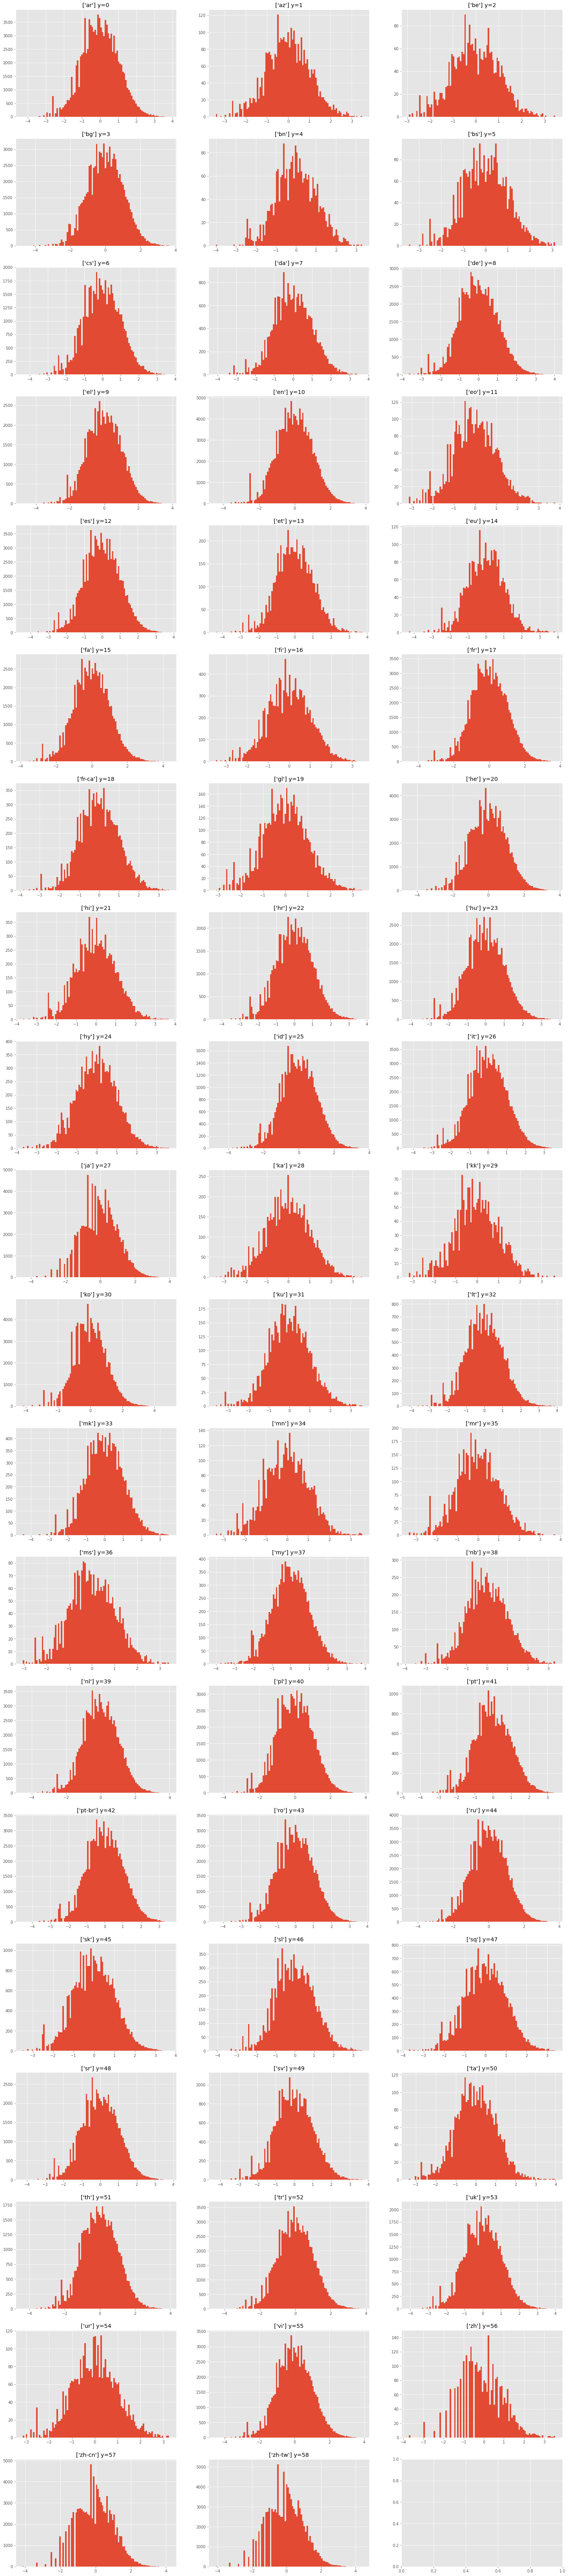

In [ ]:
fig, ax = plt.subplots(20, 3, figsize=(25,120))

n, k, i = 0, 0, 0
while i < 59:
    if n < 3:
        ax[k, n].hist(train_df.len[y == i].values, bins = 100)
        ax[k, n].set_title(str(LE.inverse_transform(np.array([i]))) + ' y='+ str(i))
        n += 1
        i += 1
    else:
        k += 1
        n = 0

In [ ]:
# train_df.iloc[y == 54, :].head(50)

# Модель

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df.sentence.values, y, random_state = SEED)

In [ ]:
pipe = Pipeline([
                 ('TfidfVectorizer', TfidfVectorizer(analyzer='char_wb', ngram_range = (1, 3))),  # запускать в колабе (1, 3) - опасно для психики
                 ('SGD',SGDClassifier(random_state=SEED, class_weight='balanced',
                                      learning_rate = 'adaptive', eta0 = 0.1,  # это тоже
                                      loss = 'perceptron', alpha=0.00001,
                                    #   early_stopping = True, validation_fraction = 0.2,
                                      n_jobs = -1)
                 )
])

In [ ]:
# pipe.fit(train_df.sentence.values, y)  # для финального предсказания

In [ ]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('TfidfVectorizer',
                 TfidfVectorizer(analyzer='char_wb', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 to...
                 SGDClassifier(alpha=1e-05, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.1, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='adaptive',
                   

In [ ]:
pred_train = pipe.predict(x_train)
pred_valid = pipe.predict(x_valid)

In [ ]:
print(balanced_accuracy_score(y_train, pred_train)) # ~0.967 c (1, 3)
print(balanced_accuracy_score(y_valid, pred_valid ))  # ~0.935 c (1, 3)

0.9678393652709542
0.9352408476248574


# Предсказание

In [ ]:
test_df.sentence = test_df.sentence.str.replace('[0-9:!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',repl='', regex=True)
test_df.sentence = test_df.sentence.str.replace('quot',repl='', regex=True)

In [ ]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [ ]:
test_df['language'] = LE.classes_[submit_predictions]

test_df.head()

In [ ]:
(
    test_df[['index', 'language']]
    .to_csv('sample_submission.csv', index=False)
)